# Project 3

---

This Notebook and the generated pdf report are my implementation of the third Udacity project.

This Notebook was ran on my local machine with GPU support.

Note that the entire training took around 50 minutes.

You will find comments per cell block and comments along the code (ddpg_agent.py and model.py) to explain the implementation. As suggested by Udacity, you can already use their provided code for DDPG and their neural network implementation. Simple adjustments are then made to adapt this code to work with implementation for Unity ml-agent as their initial code is done for Gym environments.
However, the neural network and hyperparameters needed a lot of tuning as discussed at the end.

Have fun reading through the code and results. I have solved the environment within 1414 Episodes with +0.5 reward averaged over 100 episodes as required. Future plans are discussed at the end of the report.

# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent_adjusted import Agent

In [8]:
# load the same agent from Udacity's DDPG with this env state and action sizes
agent = Agent(state_size=state_size, action_size=action_size, random_seed=15320, agents_number=2)

In [9]:
def MAddpg(n_episodes=2000, max_t=1000):

    scores_all_agents = []                        # list containing scores from each episode
    scores_window_all_agents = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(1, n_episodes+1):
        
        # resetting the environment and all agents for each episode and getting their initial state
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        for t in range(max_t):
#             print(t)    
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones) #updating the experience replay and updating weights of the learning model for all agents
            
            
            states = next_states                               # roll over states to next time step
            scores += rewards                         # update the score (for each agent)
            
            
            if np.any(dones):                                  # exit loop if episode finished
                break
                
                
#         print(scores)
#         print(np.mean(scores))
        scores_window_all_agents.append(np.max(scores))       # save most recent score
        scores_all_agents.append(np.max(scores))              # save most recent score
        
#         print(scores_window_all_agents)
        
        
        if i_episode % 25 == 0:
            
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window_all_agents), np.mean(scores)), end="")
        
            
#             torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_multi_agents.pth')
#             torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_multi_agents.pth')
        
        if np.mean(scores_window_all_agents)>=0.50 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100, np.mean(scores_window_all_agents)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_multi_agents.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_multi_agents.pth')
            break
    return scores_all_agents

In [10]:
scores = MAddpg()

c:\users\amgo02\anaconda3\envs\drlnd2\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1500	Average Score: 0.42	Score: 0.800
Environment solved in 1414 episodes!	Average Score: 0.51


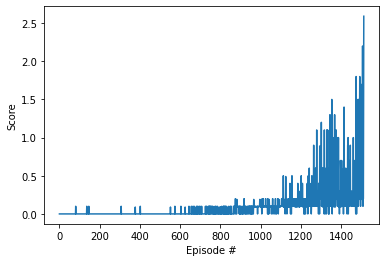

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
env.close()

# Results

At first, I tried training the two agents without having a shared replay buffer (i.e., without Self-play), and the models already reached the minimum score of 0.5 in 826 episodes only, however, I wanted to try a shared replay buffer as suggested by Udacity. After adjusting the ddpg-agent by simply adding the the shared replay buffer. The target score was achieved in longer episodes time of 1414 episodes. You can find the other ipynb without shared replay buffer (with its corresponding traditional ddpg-agent and all its pytorch model weights) in the repo as well.

In conclusion, each agent can be trained separately by playing against another agent as if it is playing a human agent, or it can learn by playing against itself and learning from its experience in both directions. 

# Future directions

Similar to the previous project, other important factors affected the learning and its stability included the added noise to the algorithm. Thus, batch normalization was used in the neural network as well as the noise sampling technique was adjusted. An important hyperparameter in this project was also the mini batch size that was a deciding factor in its success. More stable algorithms in general can be used in future work such as PPO and SAC that are commonly used in Unity ml-agent examples. However, they also recommend using PPO as SAC is already quite unstable which is common for environments with Self-play in multiple agents scenario. For more details, check the instructions readme and Unity ml-agents repo as well as this link https://github.com/Unity-Technologies/ml-agents/blob/develop/docs/ML-Agents-Overview.md#training-in-competitive-multi-agent-environments-with-self-play.